In [1]:
# A library to avoid Python warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Install a library to aviod Tensorflow warnings
! pip install -q silence_tensorflow  

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

print()

In [3]:
import os
import random as rn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [4]:
if len(tf.config.list_physical_devices('GPU')) == 0 :
    print(f"CPU is in used")
else :
    print(f"GPU is in used")

GPU is in used


In [5]:
print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.15.0


In [6]:
root_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset' # root directory
f_names = [f_name for f_name in os.listdir(root_dir)] # names of folders (or files)
print(f"Folder (or file) names:\n{f_names}")

Folder (or file) names:
['Karacadag', 'Basmati', 'Jasmine', 'Rice_Citation_Request.txt', 'Arborio', 'Ipsala']


In [7]:
f_names.remove('Rice_Citation_Request.txt')

In [8]:
rice_classes = f_names.copy()
print(f"Rice classes:\n{', '.join(rice_classes)}")

Rice classes:
Karacadag, Basmati, Jasmine, Arborio, Ipsala


In [9]:
from PIL import Image

def samples_rice_images(rice_class):
    rice_dir = os.listdir(os.path.join(root_dir, rice_class))
    random_selection = rn.choices(rice_dir, k=5)

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, img_name in enumerate(random_selection):
        img_path = os.path.join(root_dir, rice_class, img_name)
        img = Image.open(img_path)  
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

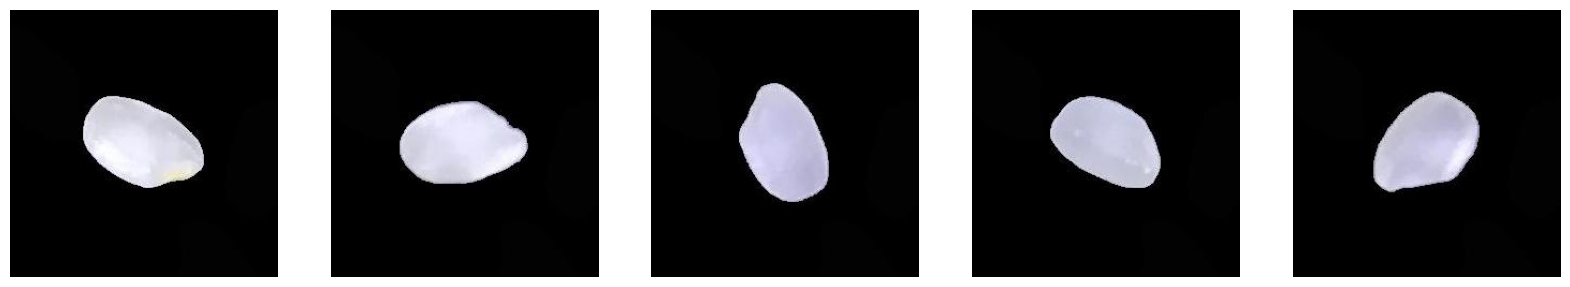

In [10]:
samples_rice_images("Karacadag")

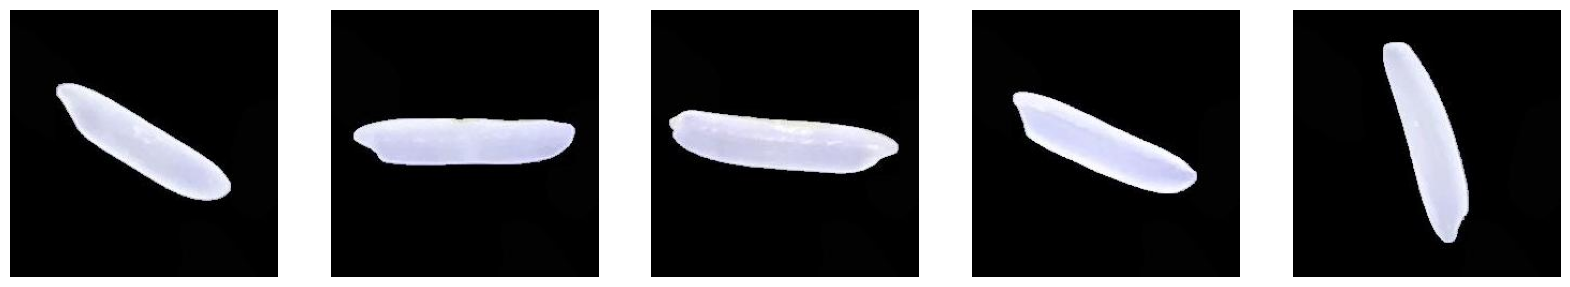

In [11]:
samples_rice_images("Basmati")

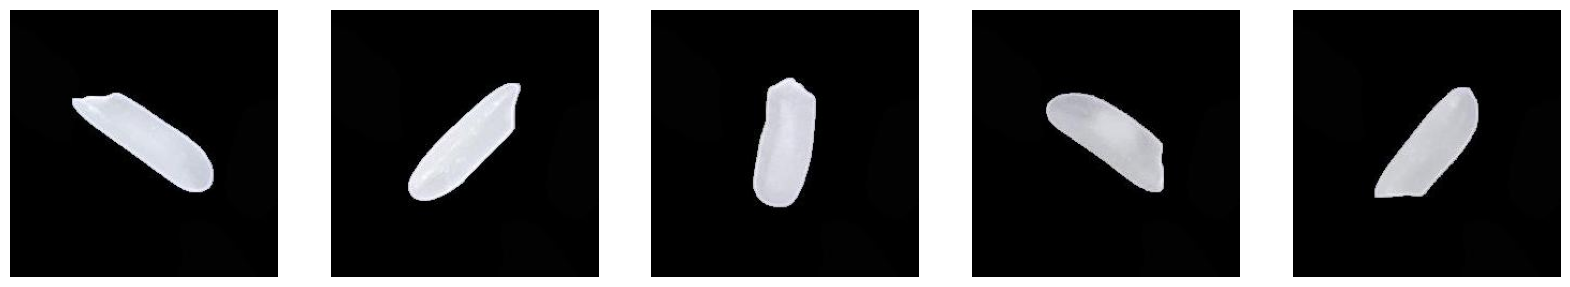

In [12]:
samples_rice_images("Jasmine")

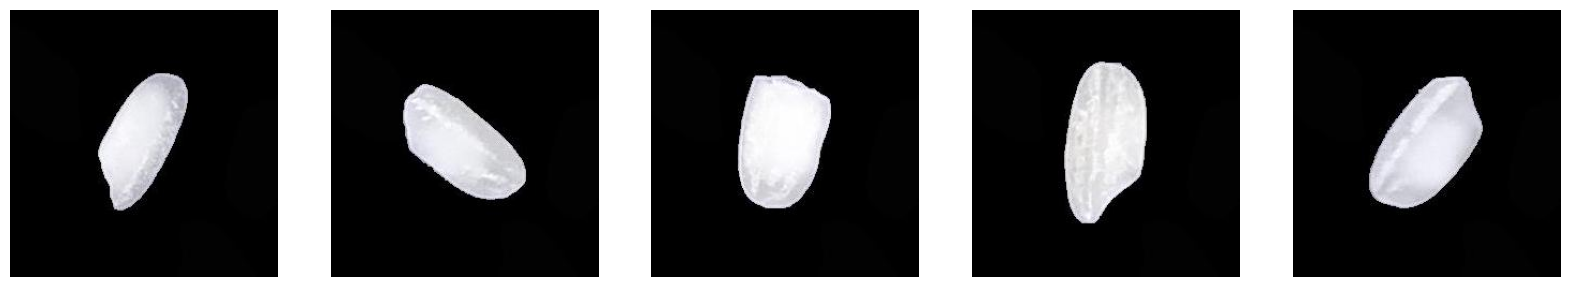

In [13]:
samples_rice_images("Arborio")

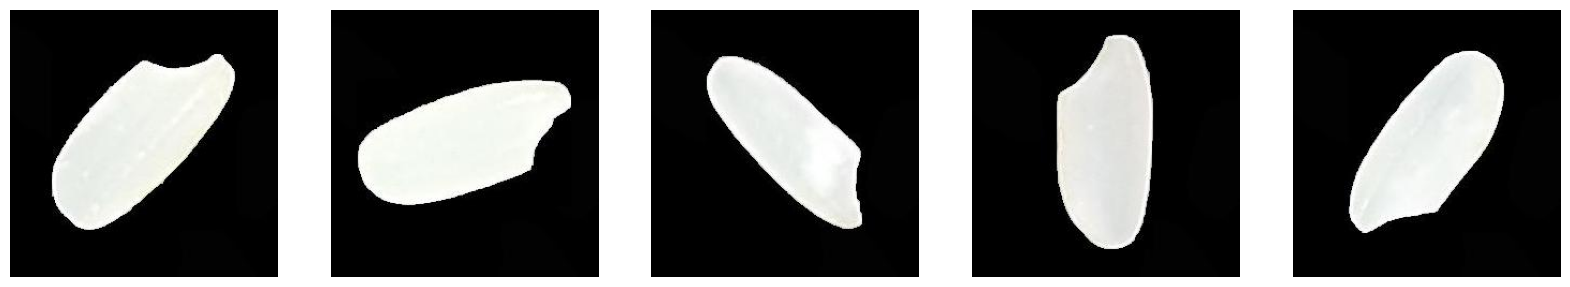

In [14]:
samples_rice_images("Ipsala")

In [15]:
# Create a dictionary that the key is the rice class and the value is the number of each classes in it
classes_counts = {rice_class: len(os.listdir(os.path.join(root_dir, rice_class))) for rice_class in rice_classes}

In [16]:
sizes = list(classes_counts.values())
labels = list(classes_counts.keys())

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=sizes,
                             hole=0.3,
                             marker_colors=px.colors.sequential.Greens,
                             textinfo='label+percent',
                             insidetextorientation='radial')])

fig.update_layout(title='Rice Classes Distribution')
fig.show()

In [17]:
rice_list = []

for rice_class in rice_classes:
    class_dir = os.path.join(root_dir, rice_class)
    for img_path in os.listdir(class_dir):
        full_path = os.path.join(class_dir, img_path)
        rice_list.append((full_path, rice_class))

In [18]:
# Dataframe Before Shuffling
df = pd.DataFrame(rice_list, columns=["File_Path", "Label"])

In [19]:
df.head(10)

,File_Path,Label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
5,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
6,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
7,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
8,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
9,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


In [20]:
# Dataframe After Shuffling
df = df.sample(frac=1).reset_index(drop=True)

In [21]:
df.head(10)

,File_Path,Label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
5,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
6,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
7,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
8,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
9,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati


In [22]:
total_samples = df.shape[0]
print(f"Total number of samples is {total_samples}")

Total number of samples is 75000


In [23]:
0.15 * total_samples, 0.7 * total_samples

(11250.0, 52500.0)

In [24]:
train_set = df[:52500].copy() # 70% of data
validate_set = df[52500:63750].copy()  # 15% of data
test_set = df[63750:].copy() # 15% of data

In [25]:
def train_calidate_test_plot():
    colors = ['#4CAF50', '#7CB342', '#CDDC39', '#FFEB3B', '#FFC107', '#FF9800', '#FF5722', '#F44336', '#E91E63', '#9C27B0']

    category_counts = df['Label'].value_counts()
    categories = category_counts.index.tolist()
    counts = category_counts.values.tolist()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, (subset, subset_name) in enumerate(zip([train_set, validate_set, test_set], ['Training Set', 'Validation Set', 'Test Set'])):
        subset_category_counts = subset['Label'].value_counts()
        subset_counts = subset_category_counts.values.tolist()

        total_count = len(subset)
        percentages = [count / total_count * 100 for count in subset_counts]

        wedges, _, autotexts = axs[i].pie(subset_counts, labels=subset_category_counts.index, autopct=lambda p: f'{p:.1f}%\n({total_count * p / 100:.0f})', colors=colors, textprops={'color': 'black', 'fontsize': 10})
        axs[i].set_title(f'{subset_name} ({total_count})')

        for autotext in autotexts:
            autotext.set_horizontalalignment('center')
            autotext.set_verticalalignment('center')

    plt.tight_layout()
    plt.show()

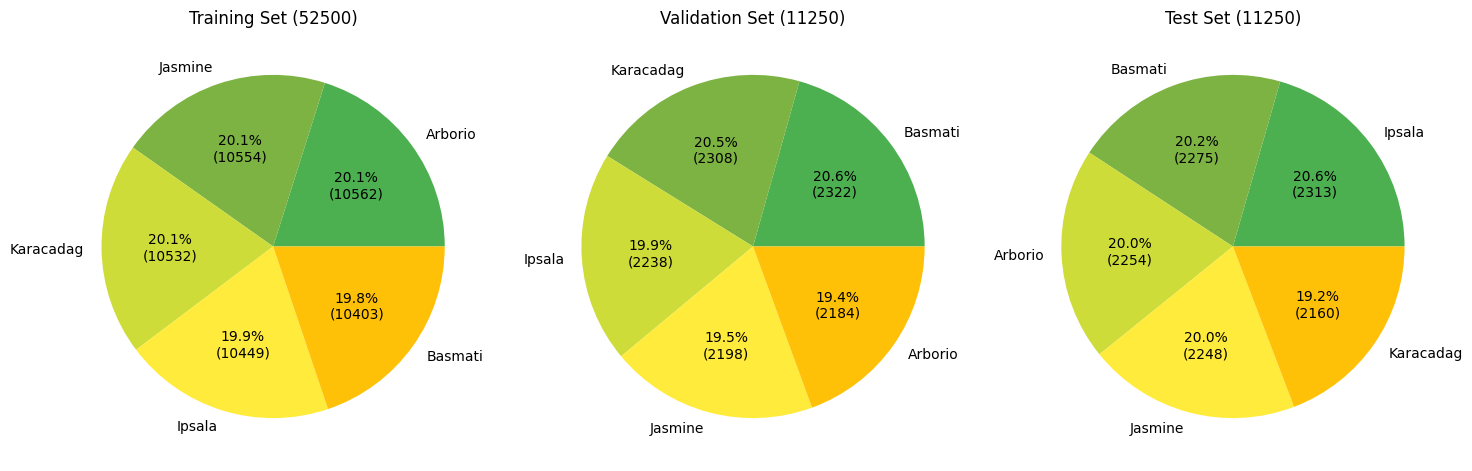

In [26]:
train_calidate_test_plot()

In [27]:
image_path = df["File_Path"][0]
image = Image.open(image_path)

width, height = image.size

print("Check the size of a sample image")
print(f"{df['Label'][0]} -> Width: {width}, Height: {height}")

Check the size of a sample image
Karacadag -> Width: 250, Height: 250


In [28]:
epochs = 10
batch_size = 32
img_height = 224
img_width = 224

In [29]:
data_generator = ImageDataGenerator(rescale=1./255)

train_generator = data_generator.flow_from_dataframe(
  dataframe=train_set,
  x_col="File_Path",
  y_col="Label",
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode="categorical",
  shuffle=True,
  seed=42
)

validation_generator = data_generator.flow_from_dataframe(
  dataframe=validate_set,
  x_col="File_Path",
  y_col="Label",
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode="categorical",
  shuffle=False,
  seed=42
)

test_generator = data_generator.flow_from_dataframe(
  dataframe=test_set,
  x_col="File_Path",
  y_col="Label",
  target_size=(img_height, img_width),
  batch_size=batch_size,
  class_mode="categorical",
  shuffle=False,
  seed=42
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


In [30]:
for image_batch, labels_batch in train_generator:
    print(f"Train Shape: {image_batch.shape} (Batches = {len(train_generator)})")
    print(f"Train label: {labels_batch.shape}\n")
    break
    
for image_batch, labels_batch in validation_generator:
    print(f"Validation Shape: {image_batch.shape} (Batches = {len(validation_generator)})")
    print(f"Validation label: {labels_batch.shape}\n")
    break
    
for image_batch, labels_batch in test_generator:
    print(f"Test Shape: {image_batch.shape} (Batches = {len(test_generator)})")
    print(f"Test label: {labels_batch.shape}\n")
    break

Train Shape: (32, 224, 224, 3) (Batches = 1641)
Train label: (32, 5)

Validation Shape: (32, 224, 224, 3) (Batches = 352)
Validation label: (32, 5)

Test Shape: (32, 224, 224, 3) (Batches = 352)
Test label: (32, 5)



In [31]:
CNN_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  
])


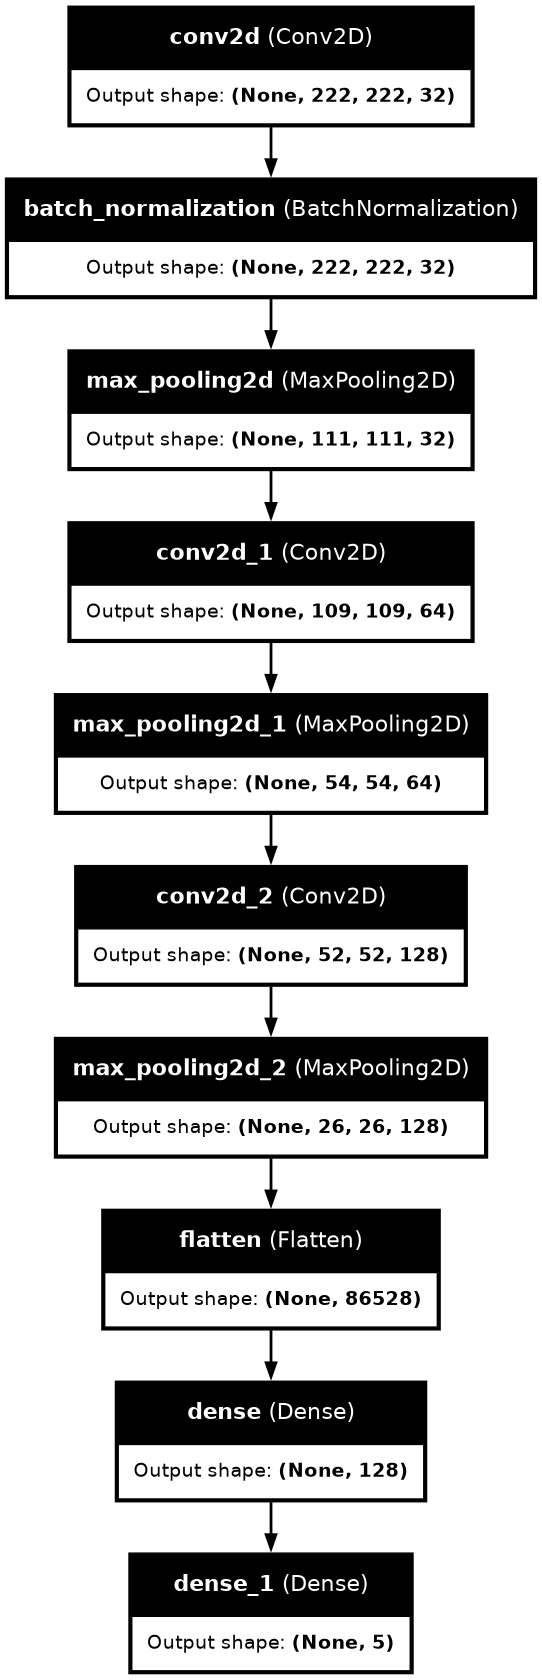

In [33]:
plot_model(CNN_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100, expand_nested=True)

In [34]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,733 (42.61 MB)

 Trainable params: 11,169,669 (42.61 MB)

 Non-trainable params: 64 (256.00 B)

In [35]:
CNN_model.compile(loss=BinaryCrossentropy(),
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

In [36]:
CNN = CNN_model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

Epoch 1/10
   2/1641 ━━━━━━━━━━━━━━━━━━━━ 1:24 52ms/step - accuracy: 0.1328 - loss: 2.3920  

I0000 00:00:1716804899.005634     147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716804899.024209     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9274 - loss: 0.1203

W0000 00:00:1716805247.089608     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 426s 252ms/step - accuracy: 0.9274 - loss: 0.1203 - val_accuracy: 0.9853 - val_loss: 0.0189
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 120s 73ms/step - accuracy: 0.9919 - loss: 0.0108 - val_accuracy: 0.9684 - val_loss: 0.0401
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 104s 63ms/step - accuracy: 0.9933 - loss: 0.0088 - val_accuracy: 0.9852 - val_loss: 0.0206
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 107s 65ms/step - accuracy: 0.9947 - loss: 0.0068 - val_accuracy: 0.9810 - val_loss: 0.0239
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 108s 65ms/step - accuracy: 0.9964 - loss: 0.0045 - val_accuracy: 0.9962 - val_loss: 0.0058
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 103s 63ms/step - accuracy: 0.9970 - loss: 0.0045 - val_accuracy: 0.9965 - val_loss: 0.0054
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 106s 64ms/step - accuracy: 0.9964 - loss: 0.0049 - val_accuracy: 0.9956 - val_loss: 0.0068
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 105s 64ms/step - accuracy: 0.9985 - l

In [37]:
CNN_model.save('CNN_model.h5')
history_CNN = CNN.history

In [38]:
AlexNet_model = models.Sequential([
    layers.Conv2D(96, 11, strides=4, activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Conv2D(256, 5, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Conv2D(384, 3, activation='relu'),
    layers.Conv2D(384, 3, activation='relu'),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

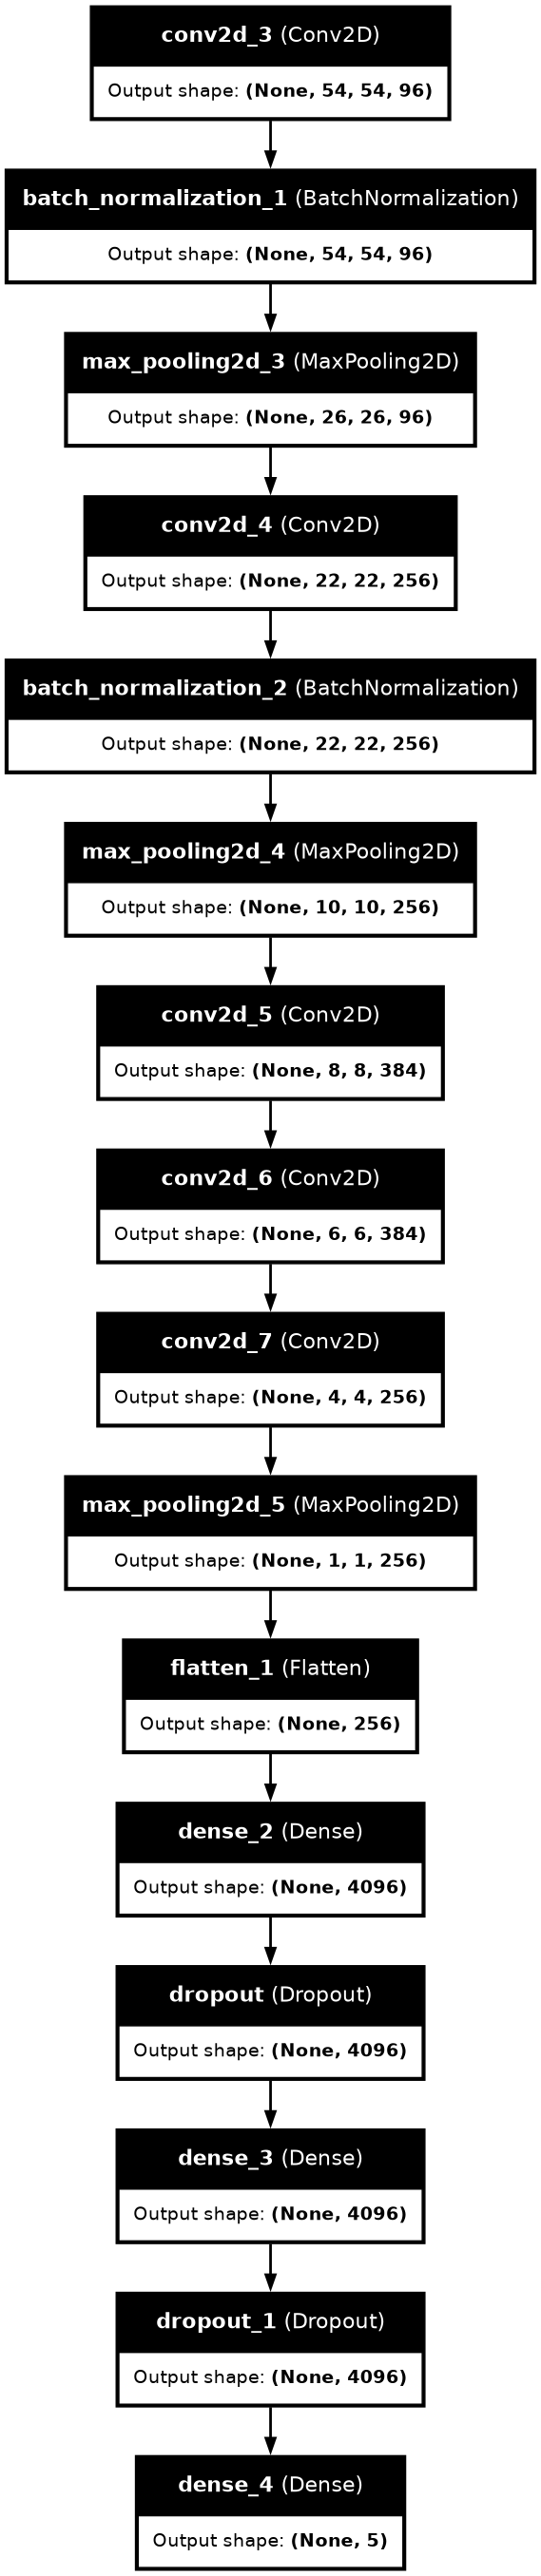

In [39]:
plot_model(AlexNet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100, expand_nested=True)

In [40]:
AlexNet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,603,077 (82.41 MB)

 Trainable params: 21,602,373 (82.41 MB)

 Non-trainable params: 704 (2.75 KB)

In [41]:
AlexNet_model.compile(loss=BinaryCrossentropy(),
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

In [42]:
AlexNet = AlexNet_model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 130s 71ms/step - accuracy: 0.8559 - loss: 0.1660 - val_accuracy: 0.8872 - val_loss: 0.1259
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 104s 63ms/step - accuracy: 0.9583 - loss: 0.0550 - val_accuracy: 0.9580 - val_loss: 0.0552
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 110s 67ms/step - accuracy: 0.9724 - loss: 0.0404 - val_accuracy: 0.9709 - val_loss: 0.0441
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 103s 63ms/step - accuracy: 0.9772 - loss: 0.0349 - val_accuracy: 0.9836 - val_loss: 0.0235
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 103s 62ms/step - accuracy: 0.9796 - loss: 0.0306 - val_accuracy: 0.9816 - val_loss: 0.0267
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 111s 67ms/step - accuracy: 0.9809 - loss: 0.0274 - val_accuracy: 0.9831 - val_loss: 0.0257
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 109s 66ms/step - accuracy: 0.9828 - loss: 0.0269 - val_accuracy: 0.9439 - val_loss: 0.1075
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 104s 63ms/step - accuracy: 

In [43]:
AlexNet_model.save('AlexNet_model.h5')
history_alex = AlexNet.history

In [44]:
def eval_result(Model1, history1, Model2, history2):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    axs[0, 0].plot(history1['accuracy'], color='green', label=f'{Model1} Train Accuracy')
    axs[0, 0].plot(history2['accuracy'], '--', color='blue', label=f'{Model2} Train Accuracy')
    axs[0, 0].set_title('Train Accuracy Comparison')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend(loc='best')
    axs[0, 0].tick_params(axis='both', which='both', direction='in', labelsize=12)

    axs[0, 1].plot(history1['val_accuracy'], color='green', label=f'{Model1} Validation Accuracy')
    axs[0, 1].plot(history2['val_accuracy'], '--', color='blue', label=f'{Model2} Validation Accuracy')
    axs[0, 1].set_title('Validation Accuracy Comparison')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend(loc='best')
    axs[0, 1].tick_params(axis='both', which='both', direction='in', labelsize=12)

    axs[1, 0].plot(history1['loss'], color='green', label=f'{Model1} Train Loss')
    axs[1, 0].plot(history2['loss'], '--', color='blue', label=f'{Model2} Train Loss')
    axs[1, 0].set_title('Train Loss Comparison')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend(loc='best')
    axs[1, 0].tick_params(axis='both', which='both', direction='in', labelsize=12)

    axs[1, 1].plot(history1['val_loss'], color='green', label=f'{Model1} Validation Loss')
    axs[1, 1].plot(history2['val_loss'], '--', color='blue', label=f'{Model2} Validation Loss')
    axs[1, 1].set_title('Validation Loss Comparison')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend(loc='best')
    axs[1, 1].tick_params(axis='both', which='both', direction='in', labelsize=12)

    plt.tight_layout()
    plt.show()

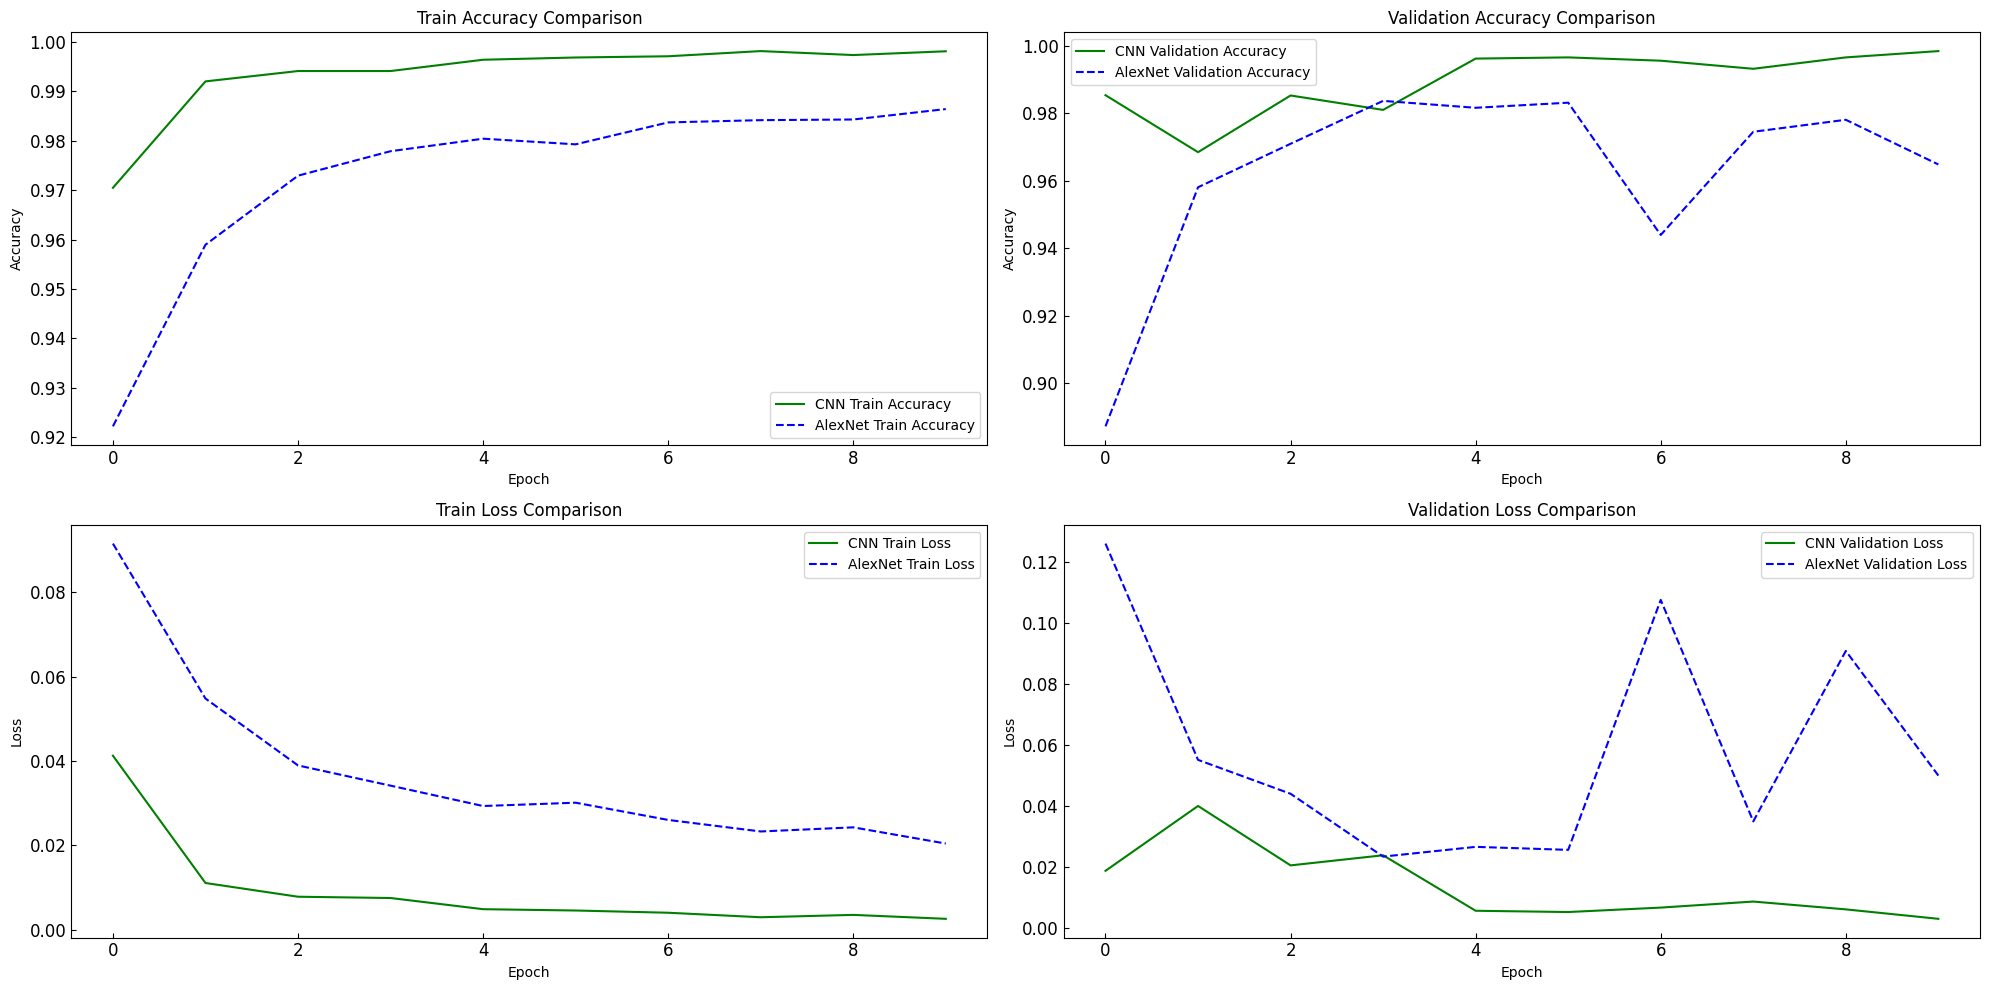

In [45]:
eval_result("CNN", history_CNN, "AlexNet", history_alex)

In [46]:
load_CNN = tf.keras.models.load_model('CNN_model.h5')
load_Alex = tf.keras.models.load_model('AlexNet_model.h5')

In [47]:
def plot_confusion_matrix(conf_matrix, class_labels, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix of {model_name}')
    plt.show()

def print_classification_report(true_classes, predicted_classes, class_labels, model_name):
    print(f"Classification Report for {model_name} Model:\n")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

def evaluate_model(load_model, test_generator, class_labels, model_name):
    predictions = load_model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    
    return conf_matrix, true_classes, predicted_classes

conf_matrix_CNN, true_classes_CNN, predicted_classes_CNN = evaluate_model(load_CNN, test_generator, rice_classes, "CNN")
conf_matrix_AlexNet, true_classes_AlexNet, predicted_classes_AlexNet = evaluate_model(load_Alex, test_generator, rice_classes, "AlexNet")

  3/352 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step  

W0000 00:00:1716807475.919802     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


352/352 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step


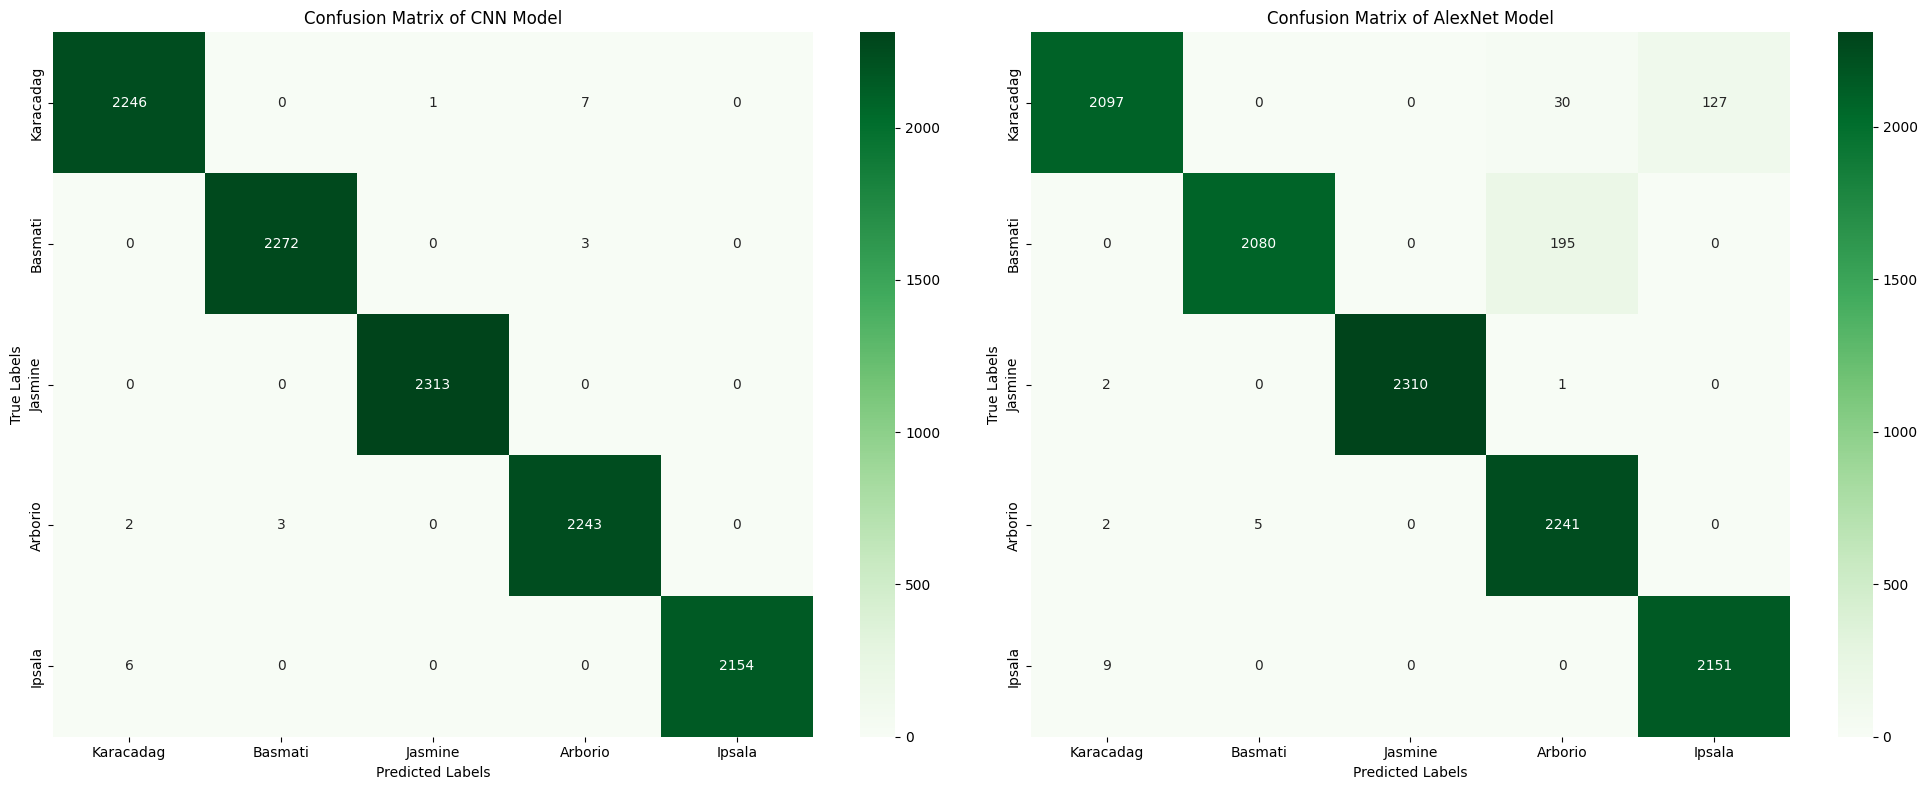

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(conf_matrix_CNN, annot=True, fmt='d', cmap='Greens', xticklabels=rice_classes, yticklabels=rice_classes, ax=axs[0])
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Confusion Matrix of CNN Model')

sns.heatmap(conf_matrix_AlexNet, annot=True, fmt='d', cmap='Greens', xticklabels=rice_classes, yticklabels=rice_classes, ax=axs[1])
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Confusion Matrix of AlexNet Model')

plt.tight_layout()
plt.show()

In [49]:
print_classification_report(true_classes_CNN, predicted_classes_CNN, rice_classes, "CNN")
print(53*"*")
print_classification_report(true_classes_AlexNet, predicted_classes_AlexNet, rice_classes, "AlexNet")

Classification Report for CNN Model:

              precision    recall  f1-score   support

   Karacadag       1.00      1.00      1.00      2254
     Basmati       1.00      1.00      1.00      2275
     Jasmine       1.00      1.00      1.00      2313
     Arborio       1.00      1.00      1.00      2248
      Ipsala       1.00      1.00      1.00      2160

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250

*****************************************************
Classification Report for AlexNet Model:

              precision    recall  f1-score   support

   Karacadag       0.99      0.93      0.96      2254
     Basmati       1.00      0.91      0.95      2275
     Jasmine       1.00      1.00      1.00      2313
     Arborio       0.91      1.00      0.95      2248
      Ipsala       0.94      1.00      0.97      2160

    accuracy                           0.97     112

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


W0000 00:00:1716807943.039459     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


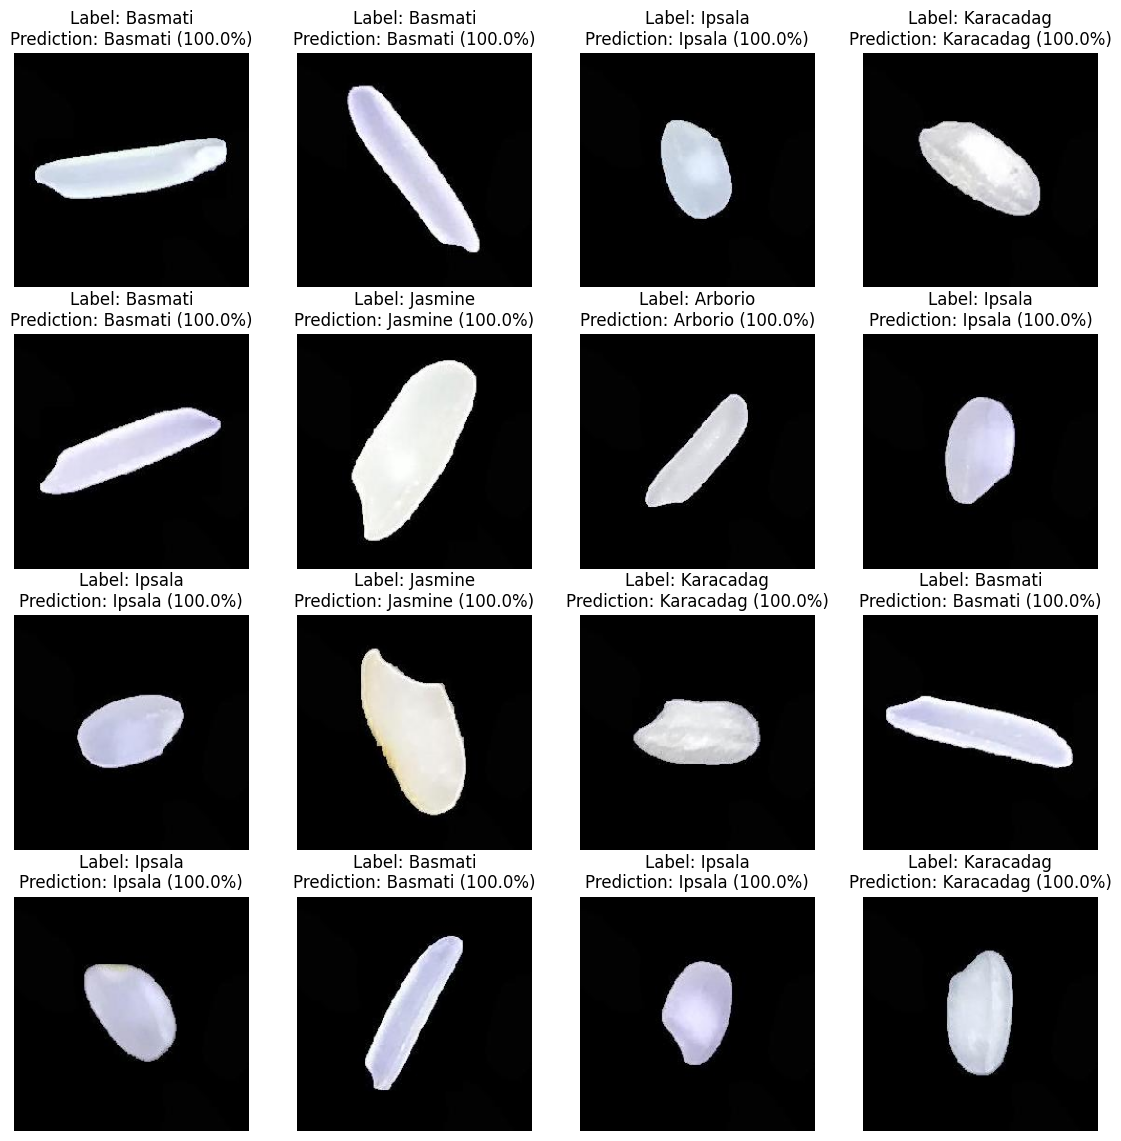

In [50]:
test_generator.reset()

images, labels = next(test_generator)

predictions = CNN_model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=[14, 14])
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title("Label: {}\nPrediction: {} ({:.1f}%)".format(
        rice_classes[np.argmax(labels[i])], 
        rice_classes[predicted_classes[i]], 
        100 * np.max(predictions[i])
    ))
    
plt.show()    